### Fetch Data from Hosts Online

In [1]:
from src.api_utils import embase_access, ilove_access, cochrane_access, medline_access, ovid_access, medline_class_access, ovid_new_access


In [2]:
cochrane_service = cochrane_access()
cochrane_service

Validation result: [{'isValid': True, 'error': '', 'rowIndex': 1, 'locale': 'en_US', 'warning': False}]
Generated email: 7eubmzla@gmail.com
Generated email: 6ytuuzac@gmail.com
Generated email: slq848nm@gmail.com
Generated email: r3qxpp20@gmail.com
Generated email: p2hzw7i5@gmail.com
Generated email: 99pb3vpv@gmail.com
Generated email: ozo2qplv@gmail.com
Generated email: lj0t1jfq@gmail.com
Generated email: x6htq5w6@gmail.com
Generated email: o221o9wn@gmail.com
Generated email: jw8qxrpo@gmail.com
Generated email: rn573hjy@gmail.com
Generated email: z5jw3cg1@gmail.com
Generated email: 9fq83cfa@gmail.com
Generated email: uwhi1v8p@gmail.com
Generated email: 01gflubr@gmail.com
Generated email: 1b38ulxh@gmail.com
Generated email: muwm29g6@gmail.com
Generated email: cv1phdx3@gmail.com
Generated email: stsuuv27@gmail.com
Generated email: x6g25h60@gmail.com
Generated email: erfim857@gmail.com
Generated email: hceaxn61@gmail.com
Generated email: 88brqxvj@gmail.com
Generated email: rj2panj7@gmail.

In [ ]:
ilove_access()

In [2]:
medline_class_access(searchText=["covid-19 vaccine human china"])

Processing query: covid-19 vaccine human china
Total IDs retrieved for query 'covid-19 vaccine human china': 4970
Found 4970 articles for query: covid-19 vaccine human china


KeyboardInterrupt: 

In [ ]:
ovid_access()

In [3]:
ovid_new_access()

{'S': 'BCGGFPLEGDACKLOAKPIJIHMIOHBKAA00', 'Get Bib Display': 'Titles|G|S.sh.25|1|100', 'on_msp': '1', 'CitManPrev': 'S.sh.25|1|100', 'undefined': 'Too many results to sort', 'cmRecords': ['Ex: 1-4, 7', 'Ex: 1-4, 7'], 'results_per_page': ['100', '100'], 'startRecord': '1', 'FORMAT': ['title', 'title'], 'FIELDS': ['SELECTED', 'SELECTED'], 'output mode': 'display', 'WebLinkReturn': 'Titles=S.sh.25|1|100', 'Datalist': 'S.sh.25|1|100', 'gsrd_params': 'S.sh.25|1|100|', 'analytics_display': 'msp', 'startRecord_subfooter': '1', 'SELECT': 'S.sh.25|', 'issue_record_range': '1-51215'}
Fetching page 1: https://ovidsp.dc1.ovid.com/ovid-new-b/ovidweb.cgi?S=BCGGFPLEGDACKLOAKPIJIHMIOHBKAA00&Get Bib Display=Titles|G|S.sh.25|1|100&on_msp=1&CitManPrev=S.sh.25|1|100&undefined=Too many results to sort&cmRecords=Ex: 1-4, 7&cmRecords=Ex: 1-4, 7&results_per_page=100&results_per_page=100&startRecord=1&FORMAT=title&FORMAT=title&FIELDS=SELECTED&FIELDS=SELECTED&output mode=display&WebLinkReturn=Titles=S.sh.25|1|1

In [1]:
from src.Commands.PaperProcessorPipeline import PaperProcessorPipeline
from concurrent.futures import ThreadPoolExecutor
def main():
    pipeline = PaperProcessorPipeline(
        table_name='all_db',
        column_mapping={'Id': 'primary_id'}
    )

    sources = [
        {
            "query": "SELECT primary_id, \"DOI\" FROM all_db WHERE \"Source\"='Cochrane'",
            "csv_file_path": "output/papers_data",
            "db_name": "Cochrane"
        },
        # {
        #     "query": "SELECT primary_id, \"DOI\" FROM all_db WHERE \"Source\"='LOVE'",
        #     "csv_file_path": "output/papers_data_love",
        #     "db_name": "LOVE"
        # },
        # {
        #     "query": "SELECT primary_id, \"DOI\" FROM all_db WHERE \"Source\"='OVID'",
        #     "csv_file_path": "output/papers_data_OVID",
        #     "db_name": "OVID"
        # },
        # {
        #     "query": "SELECT primary_id, \"DOI\" FROM all_db WHERE \"Source\"='Medline'",
        #     "csv_file_path": "output/papers_data_medline",
        #     "db_name": "Medline"
        # }
    ]

    # Use parallel processing to process multiple sources simultaneously
    with ThreadPoolExecutor(max_workers=4) as executor:
        executor.map(
            lambda source: pipeline.process_source_in_batches(
                query=source["query"],
                csv_file_path=source["csv_file_path"],
                db_name=source["db_name"],
                batch_size=10
            ),
            sources
        )

if __name__ == "__main__":
    main()

                   Outcome#Death#Death  \
0                            mortality   
1  death, mortality, overall mortality   
2                     death, mortality   
3                            mortality   
4                     death, mortality   
5                     death, mortality   
6                            mortality   
7                            mortality   
8                            mortality   
9                            mortality   

                              Reviews#Reviews#review  \
0                                             review   
1           Meta-Analysis, review, systematic review   
2  Literature Review, Meta-Analysis, systematic r...   
3                              Meta-Analysis, review   
4  Peer Review, Meta-Analysis, review, systematic...   
5  Literature Review, Meta-Analysis, systematic r...   
6  Peer Review, Meta-Analysis, review, systematic...   
7  Meta-Analysis, systematic review, Peer Review,...   
8  Peer Review, Meta-Analysis, Re

In [2]:
import pandas as pd
from src.Commands.DatabaseUpdater import DatabaseUpdater

updater = DatabaseUpdater(table_name="all_db", column_mapping={'Id': 'Id'})

def convert_chart(chart):
    try:
        # Get the currently active data transformer
        current_transformer = alt.data_transformers.get()
        # Check if the current transformer is vegafusion
        if 'vegafusion' in str(current_transformer):
            return chart.to_dict(format="vega")
        else:
            return chart.to_dict()
    except ValueError as e:
        print(f"Handling ValueError: {e}")
        return chart.to_dict()
    
def view_trends_by_database_year():
    final_data = None
    # if "database" in final_data:
    #     # Rename databases for better readability
    #     databases = {
    #         'OVID': 'OVID',
    #         'LOVE': 'LOVE DB',
    #         'Medline': 'Medline',
    #         'Cochrane': 'Cochrane'
    #     }
    #     final_data['database'] = final_data['database'].replace(databases)
    
    # # Compute the crosstab with cumulative sum
    # d = pd.crosstab(final_data['Year'], final_data['database'], values=final_data['count'], aggfunc='sum').cumsum()

    # # Reset the index to get 'bibliography_year' as a column
    # d = d.reset_index()

    # # Melt the dataframe to convert it into long format for Altair
    # d_melted = d.melt(id_vars='bibliography_year', var_name='database', value_name='count')

    # # Compute percentage for stacked bar chart
    # # Ensure that percentages are calculated correctly and aligned
    # d_melted['percentage'] = d_melted.groupby('bibliography_year')['count'].transform(lambda x: x / x.sum() * 100)

    # custom_colors = {
    #     'MPstruc (Membrane Protein Structures)': '#fff',  # Blue for MPstruc
    #     'UniProt (Universal Protein Resource)': '#8da0cb',  # Orange for UniProt
    #     'PDB (Protein Data Bank)': 'lightgrey',  # Blue for PDB
    #     'OPM (Orientation of Proteins in Membranes)': '#66c2a5',  # Green for OPM
    # }
    
    # # Add new columns to define stroke color and width based on the database
    # d_melted['stroke_color'] = d_melted['database'].map(custom_colors)

    # d_melted['stroke_width'] = d_melted['database'].map({
    #     'MPstruc (Membrane Protein Structures)': 0.3,
    #     'PDB (Protein Data Bank)': 0.3,
    #     'OPM (Orientation of Proteins in Membranes)': 0.3,
    #     'UniProt (Universal Protein Resource)': 0.3
    # })


    # order_mapping = {
    #     'MPstruc (Membrane Protein Structures)': 0, 
    #     'UniProt (Universal Protein Resource)': 1,
    #     'PDB (Protein Data Bank)': 2, 
    #     'OPM (Orientation of Proteins in Membranes)': 3, 
    # }
    # d_melted['Order'] = d_melted['database'].map(order_mapping)
    # # d_melted.to_csv("DBContribution.csv")
    # # Create the 100% stacked bar chart using Altair
    # chart = alt.Chart(d_melted).mark_bar().encode(
    #     x=alt.X('bibliography_year:O', title='Year'),
    #     y=alt.Y('percentage:Q', title='Proportional Representation of Databases Entries (%)', scale=alt.Scale(domain=[0, 100])),
    #     color=alt.Color(
    #         'database:N',
    #         scale=alt.Scale(domain=list(custom_colors.keys()), range=list(custom_colors.values())),
    #         legend=alt.Legend(
    #             title="Database", labelLimit=0, orient="bottom", direction="vertical",
    #             symbolStrokeColor="black", symbolStrokeWidth=0.5
    #         ),
    #         sort=[
    #             'MPstruc (Membrane Protein Structures)', 
    #             'UniProt (Universal Protein Resource)',
    #             'PDB (Protein Data Bank)', 
    #             'OPM (Orientation of Proteins in Membranes)', 
    #         ]
    #     ),
    #     tooltip=[
    #         alt.Tooltip('database:N', title='Database'),
    #         alt.Tooltip('bibliography_year:O', title='Year'),
    #         alt.Tooltip('percentage:Q', title='Percentage')
    #     ],
    #     order=alt.Order('Order:Q')
    # ).encode(
    #     stroke=alt.condition(
    #         alt.datum.database == 'MPstruc (Membrane Protein Structures)',  # Condition for sub_category 'X'
    #         alt.value('black'),              # Border color for selected
    #         alt.value('transparent')          # No border for unselected
    #     ),
    #     strokeWidth=alt.condition(
    #         alt.datum.database == 'MPstruc (Membrane Protein Structures)',  # Same condition for sub_category 'X'
    #         alt.value(1),                    # Border width for selected
    #         alt.value(0)                     # No border width for unselected
    #     )
    # ).properties(
    #     width=800,
    #     height=400,
    #     title="Comparative Annual Representation of Membrane Protein Entries from the MPstruc, PDB, OPM, and UniProt Databases."
    # )
    
view_trends_by_database_year()

In [5]:
from src.Commands.PaperProcessorPipeline import PaperProcessorPipeline
from concurrent.futures import ThreadPoolExecutor
def main():
    pipeline = PaperProcessorPipeline(
        table_name='rough_db',
        column_mapping={'Id': 'primary_id'}
    )

    sources = [
        {
            "query": "SELECT primary_id, \"Link to full text\" FROM rough_db WHERE primary_id > 0 and \"Link to full text\" != ''",
            "csv_file_path": "output/papers_data_rough",
            "db_name": "OVID"
        }
    ]

    # Use parallel processing to process multiple sources simultaneously
    with ThreadPoolExecutor(max_workers=4) as executor:
        executor.map(
            lambda source: pipeline.process_source_in_batches(
                query=source["query"],
                csv_file_path=source["csv_file_path"],
                db_name=source["db_name"],
                batch_size=10
            ),
            sources
        )

if __name__ == "__main__":
    main()

Analyze trends in antibiotic resistance over time?
Investigate missing data patterns?
Identify potential outliers in resistance profiles?
Explore relationships between demographic features and resistance patterns?

Show trends in antibiotic resistance data.

Identify outliers in patient age distribution

Can you calculate seasonal resistance trends?

Identify regions with highest resistance rates.

Visualize seasonal trends in resistance.

Analyze specific antibiotics by season.

## My Timeline

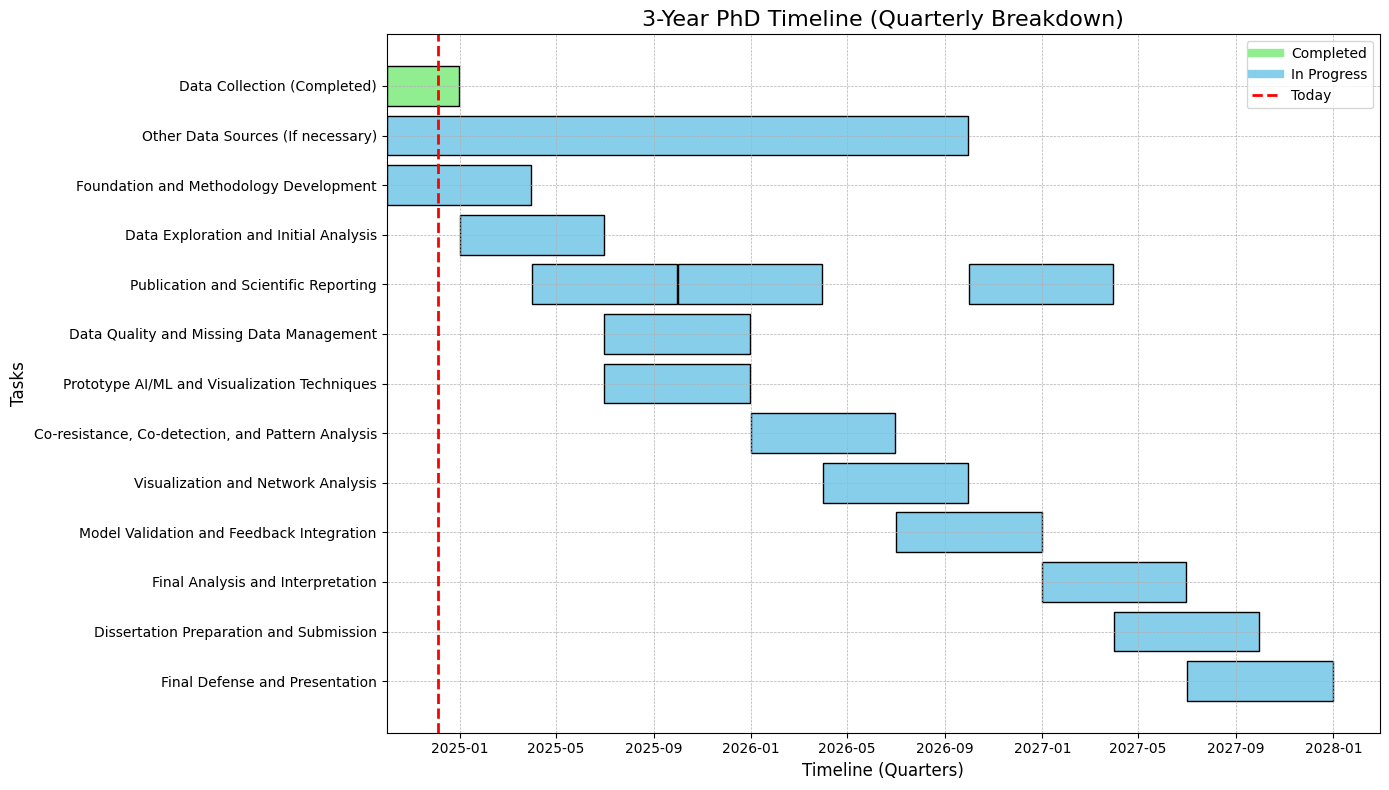

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from datetime import datetime

# Define the Gantt chart data
data = {
    "Task": [
        "Data Collection (Completed)", 
        "Other Data Sources (If necessary)",
        "Foundation and Methodology Development", 
        "Data Exploration and Initial Analysis",
        "Publication and Scientific Reporting",
        "Data Quality and Missing Data Management", 
        "Prototype AI/ML and Visualization Techniques",
        "Publication and Scientific Reporting",
        "Co-resistance, Co-detection, and Pattern Analysis",
        "Visualization and Network Analysis",
        "Model Validation and Feedback Integration",
        "Publication and Scientific Reporting",
        "Final Analysis and Interpretation",
        "Dissertation Preparation and Submission",
        "Final Defense and Presentation"
    ],
    "Start": [
        "2024-10-01", "2024-10-01", "2024-10-01", "2025-01-01", "2025-04-01", 
        "2025-07-01", "2025-07-01", "2025-10-01", "2026-01-01", 
        "2026-04-01", "2026-07-01", "2026-10-01", "2027-01-01", 
        "2027-04-01", "2027-07-01"  # Added missing start date
    ],
    "End": [
        "2024-12-31", "2026-09-30", "2025-03-31", "2025-06-30", "2025-09-30", 
        "2025-12-31", "2025-12-31", "2026-03-31", "2026-06-30", 
        "2026-09-30", "2026-12-31", "2027-03-31", "2027-06-30", 
        "2027-09-30", "2027-12-31"  # Added missing end date
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Convert Start and End to datetime
df["Start"] = pd.to_datetime(df["Start"])
df["End"] = pd.to_datetime(df["End"])

# Get the current date for the vertical line
current_date = datetime.now()

# Create the Gantt chart
fig, ax = plt.subplots(figsize=(14, 8))

for i, task in df.iterrows():
    color = "lightgreen" if "Completed" in task["Task"] else "skyblue"
    ax.barh(task["Task"], date2num(task["End"]) - date2num(task["Start"]),
            left=date2num(task["Start"]), color=color, edgecolor="black")

# Add the current date line
ax.axvline(date2num(current_date), color="red", linestyle="--", linewidth=2, label="Today")

# Add labels and formatting
ax.set_title("3-Year PhD Timeline (Quarterly Breakdown)", fontsize=16)
ax.set_xlabel("Timeline (Quarters)", fontsize=12)
ax.set_ylabel("Tasks", fontsize=12)
ax.xaxis_date()
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.invert_yaxis()  # Flip tasks to start from the top

# Add custom legend
legend_elements = [
    plt.Line2D([0], [0], color="lightgreen", lw=6, label="Completed"),
    plt.Line2D([0], [0], color="skyblue", lw=6, label="In Progress"),
    plt.Line2D([0], [0], color="red", lw=2, linestyle="--", label="Today")
]
ax.legend(handles=legend_elements, loc="upper right", fontsize=10)

plt.tight_layout()
plt.show()


In [4]:
from src.Services.Factories.GeneralPDFScraper.OVIDPDFWebScraper import OVIDPDFWebScraper
from src.Commands.TaggingSystem import Tagging

from itertools import chain
import pandas as pd
def flatten_tags(tags):
    """Convert nested lists or other complex data types to flattened strings."""
    for key, value in tags.items():
        # Check if key starts with "Population#AgeGroup"
        if key.startswith("Population#AgeGroup") and isinstance(value, list):
            # Retain only the last item for keys starting with Population#AgeGroup
            if value:
                tags[key] = value[-1] if isinstance(value[-1], list) else value[-1]
        elif isinstance(value, list):
            # Flatten nested lists for other keys
            flattened_value = list(chain.from_iterable(
                v if isinstance(v, list) else [v] for v in value
            ))
            tags[key] = ', '.join(str(v) for v in flattened_value)
        elif isinstance(value, str):
            # Strip whitespace for strings
            tags[key] = value.strip()
    
    return tags

gen = OVIDPDFWebScraper(DB_name="OVID")
document = gen.set_doi_url(
    "http://dx.doi.org/10.2165/11599470-000000000-00000"
).fetch_and_extract_first_valid_pdf_text()

tag = Tagging(document)
from src.Commands.regexp import searchRegEx
data = tag.create_columns_from_text(searchRegEx)
data = flatten_tags(data)
# ff = pd.DataFrame(data)
# ff.to_csv("testing.csv")
data

https://link.springer.com/article/10.2165/11599470-000000000-00000?error=cookies_not_supported&code=3bb83d99-f3b2-4f4b-919f-e1fb7c629577


{'Topic#Risk__Factor#Risk__Factor': 'risk',
 'Topic#Administration#Administration': 'vaccine types, administration',
 'Topic#Economic__Aspects#Economic__Aspects': 'cost-effectiveness, economic evaluation, economic impact, economic, cost, cost effectiveness',
 'Topic#Modeling#Modeling': 'modeling',
 'Outcome#Infection#Infection': 'infection',
 'Reviews#Reviews#review': 'systematic review, Meta-Analysis, review',
 'Studies#No__Of__Studies#number__of__studies': '12 studies, 1 randomized controlled trial, 1 randomised controlled trial, 1 qualitative, 1 study, 29 studies, 4 studies',
 'total_study_count': 49,
 'total_rct_count': 0}

In [3]:
import requests

def fetch_sagepub_content(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36",
        "Accept-Language": "en-US,en;q=0.9",
        "Referer": "https://google.com"
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raise an error for bad status codes
        return response.text
    except requests.exceptions.RequestException as e:
        return f"Error: {e}"

# Example usage
url = "https://journals.sagepub.com/doi/10.1177/2150131917742299"
content = fetch_sagepub_content(url)
print(content[:1000])  # Print first 1000 characters for inspection


Error: 403 Client Error: Forbidden for url: https://journals.sagepub.com/doi/10.1177/2150131917742299


In [2]:
from src.Services.Factories.GeneralPDFScraper.CochranePDFWebScraper import CochranePDFWebScraper
from src.Commands.TaggingSystem import Tagging
from itertools import chain
import pandas as pd
def flatten_tags(tags):
    """Convert nested lists or other complex data types to flattened strings."""
    for key, value in tags.items():
        # Check if key starts with "Population#AgeGroup"
        if key.startswith("Population#AgeGroup") and isinstance(value, list):
            # Retain only the last item for keys starting with Population#AgeGroup
            if value:
                tags[key] = value[-1] if isinstance(value[-1], list) else value[-1]
        elif isinstance(value, list):
            # Flatten nested lists for other keys
            flattened_value = list(chain.from_iterable(
                v if isinstance(v, list) else [v] for v in value
            ))
            tags[key] = ', '.join(str(v) for v in flattened_value)
        elif isinstance(value, str):
            # Strip whitespace for strings
            tags[key] = value.strip()
    
    return tags
    
def load_text_as_string(filename):
    """
    Loads the content of a text file as a string.

    Args:
        filename (str): The name or path of the text file.

    Returns:
        str: The content of the file as a string.
    """
    with open(filename, 'r') as file:
        content = file.read()
    return content

document = load_text_as_string("example.txt")

tag = Tagging(document)
from src.Commands.regexp import searchRegEx
data = tag.create_columns_from_text(searchRegEx)
data = flatten_tags(data)
# ff = pd.DataFrame(data)
# ff.to_csv("testing.csv")
data

{'Population#Group#Population': "{'indicator': 'participant', 'populations': 183}, {'indicator': 'participant', 'populations': 19}, {'indicator': 'participant', 'populations': 1}, {'indicator': 'participant', 'populations': 50}, {'indicator': 'participant', 'populations': 26}, {'indicator': 'participant', 'populations': 0}, {'indicator': 'participant', 'populations': 118}, {'indicator': 'participant', 'populations': 119}, {'indicator': 'participant', 'populations': 17}, {'indicator': 'participant', 'populations': 0}, {'indicator': 'participant', 'populations': 2}, {'indicator': 'participant', 'populations': 21}, {'indicator': 'participant', 'populations': 19}, {'indicator': 'participant', 'populations': 19}, {'indicator': 'participant', 'populations': 19}, {'indicator': 'participant', 'populations': 14}, {'indicator': 'participant', 'populations': 19}, {'indicator': 'participant', 'populations': 19}, {'indicator': 'participant', 'populations': 0}, {'indicator': 'participant', 'populati

In [11]:
document = """
Six of the 21 ongoing studies investigate different doses of vitamin
D supplementation, of which all are RCTs. Two RCTs are expected to
be completed in 2021, and one RCT is expected to be completed in 2022.
"""
search_terms = [
                "study", "studies", "RCT", 
                "NRSI", "cross sectional", 
                "mixed method", "qualitative",
                'randomized controlled trial',
                'randomised controlled trial',
                'randomized trial',
                'randomised trial'
            ]

# Assuming self.document is already set
tagging = Tagging(document)
result = tagging.process_study_count(search_terms)

print("Study Counts:", result[0])
print("Total Study Count:", result[1])
print("Total RCT Count:", result[2])
print("RCT Counts:", result[3])


Skipping invalid written number: ongoing
Skipping invalid written number: are
Study Counts: []
Total Study Count: 0
Total RCT Count: 3
RCT Counts: ['2 RCT', '1 RCT']


In [11]:
def word_to_num_extended(word):
    """
    Converts a written number into its numeric equivalent, including "million", "billion", and "trillion".
    Handles "and" as a filler word.
    """
    num_dict = {
        "zero": 0, "one": 1, "two": 2, "three": 3, "four": 4, "five": 5,
        "six": 6, "seven": 7, "eight": 8, "nine": 9, "ten": 10,
        "eleven": 11, "twelve": 12, "thirteen": 13, "fourteen": 14,
        "fifteen": 15, "sixteen": 16, "seventeen": 17, "eighteen": 18,
        "nineteen": 19, "twenty": 20, "thirty": 30, "forty": 40,
        "fifty": 50, "sixty": 60, "seventy": 70, "eighty": 80,
        "ninety": 90, "hundred": 100, "thousand": 1000,
        "million": 1000000, "billion": 1000000000, "trillion": 1000000000000
    }

    tokens = re.split(r"[\s-]+", word.lower())
    total = 0
    current = 0

    for token in tokens:
        if token == "and":
            continue  # Skip "and"

        if token in num_dict:
            value = num_dict[token]
            if value in [100, 1000, 1000000, 1000000000, 1000000000000]:  # Multipliers
                if current == 0:
                    current = 1  # Ensure there's a base to multiply
                current *= value
                if value >= 1000:
                    total += current
                    current = 0
            else:
                current += value
        else:
            raise ValueError(f"Invalid number word: {token}")

    total += current
    return total


def process_study_count(document, term_list):
    """
    Corrected function to ensure accurate summation of study and RCT counts.
    """
    raw_study_counts = []
    raw_rct_counts = []

    # Replace multi-word terms with placeholders
    replacements = {
        "randomized controlled trial": "RCT",
        "randomised controlled trial": "RCT",
        "randomized trial": "RCT",
        "randomised trial": "RCT"
    }
    for phrase, replacement in replacements.items():
        document = re.sub(phrase, replacement, document, flags=re.IGNORECASE)

    # Define patterns for written numbers and multipliers
    written_numbers = {
        "a": 1, "one": 1, "two": 2, "three": 3, "four": 4, "five": 5, "six": 6,
        "seven": 7, "eight": 8, "nine": 9, "ten": 10, "eleven": 11, "twelve": 12,
        "thirteen": 13, "fourteen": 14, "fifteen": 15, "sixteen": 16, "seventeen": 17,
        "eighteen": 18, "nineteen": 19, "twenty": 20
    }
    multipliers = {
        "thousand": 1000,
        "million": 1000000,
        "billion": 1000000000,
        "trillion": 1000000000000
    }

    # Process document in smaller chunks
    chunks = document.split('.')  # Split by sentence or paragraph

    for chunk in chunks:
        for term in term_list:
            # Match digit-based numbers
            digit_pattern = re.compile(rf'\b(\d+)\s*({term})s?\b', flags=re.IGNORECASE)
            digit_matches = digit_pattern.findall(chunk)
            for count, matched_term in digit_matches:
                count_val = int(count)
                if count_val > 0:  # Filter out invalid matches like `0`
                    if matched_term.lower() == "rct":
                        raw_rct_counts.append(f"{count_val} {matched_term}")
                    else:
                        raw_study_counts.append(f"{count_val} {matched_term}")

            # Match written numbers with multipliers
            written_pattern = re.compile(
                rf'\b((?:a|\w+))\s*(thousand|million|billion|trillion)?\s*({term})s?\b',
                flags=re.IGNORECASE
            )
            written_matches = written_pattern.findall(chunk)
            for word, multiplier, matched_term in written_matches:
                try:
                    count_val = written_numbers.get(word.lower(), 0)
                    if multiplier:
                        count_val *= multipliers.get(multiplier.lower(), 1)
                    if count_val > 0:  # Filter out invalid matches like `0`
                        if matched_term.lower() == "rct":
                            raw_rct_counts.append(f"{count_val} {matched_term}")
                        else:
                            raw_study_counts.append(f"{count_val} {matched_term}")
                except ValueError:
                    continue  # Skip invalid words

    # Deduplicate before summing totals
    unique_study_counts = list(set(raw_study_counts))
    unique_rct_counts = list(set(raw_rct_counts))

    # Recalculate totals from unique counts
    total_study_count = sum(int(item.split()[0]) for item in unique_study_counts)
    total_rct_count = sum(int(item.split()[0]) for item in unique_rct_counts)

    return unique_study_counts, total_study_count, total_rct_count, unique_rct_counts


document = load_text_as_string("example.txt")
search_terms = [
    "study", "studies", "RCT", 
    "NRSI", "cross sectional", 
    "mixed method", "qualitative",
    'randomized controlled trial',
    'randomised controlled trial',
    'randomized trial',
    'randomised trial'
]
# Retry with the optimized function
study_counts, total_study_count, total_rct_count, rct_counts = process_study_count(document, search_terms)

# Output results
(study_counts, total_study_count, rct_counts, total_rct_count)


(['9 studies',
  '2 studies',
  '19 Study',
  '3 studies',
  '5 studies',
  '6 studies',
  '62 studies',
  '13 studies',
  '2 study',
  '1 study',
  '20 studies',
  '21 studies'],
 163,
 ['3 RCT', '1 RCT', '14 RCT', '2 RCT'],
 20)

In [5]:
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
import json
import time

def load_cookies(driver, cookies_file):
    """
    Load cookies from a file into the Selenium driver.

    Parameters:
        driver: Selenium WebDriver instance.
        cookies_file: Path to the JSON file containing cookies.
    """
    with open(cookies_file, "r") as file:
        cookies = json.load(file)
        for cookie in cookies:
            driver.add_cookie(cookie)

def fetch_all_content(url, cookies_file, output_file):
    """
    Fetches all visible content from a webpage using Selenium and saves it to a file.

    Parameters:
        url: The URL of the webpage to fetch.
        cookies_file: Path to the JSON file containing cookies.
        output_file: Path to the file where content will be saved.

    Returns:
        str: Success message or an error message.
    """
    try:
        # Start an undetected Chrome browser
        driver = uc.Chrome()

        # Open the target page
        driver.get(url)

        # Load cookies
        load_cookies(driver, cookies_file)

        # Refresh the page to apply cookies
        driver.refresh()
        time.sleep(3)

        # Extract all visible content from all elements
        try:
            all_elements = driver.find_elements(By.XPATH, "//*")
            all_text = "\n".join([element.text.strip() for element in all_elements if element.text.strip()])
        except Exception:
            all_text = "Content not found."

        # Save the extracted content to a file
        with open(output_file, "w", encoding="utf-8") as file:
            file.write(all_text)

        driver.quit()

        return f"All content saved to {output_file}"

    except Exception as e:
        return f"Error occurred: {e}"


# Example Usage
url = "https://www.sciencedirect.com/science/article/abs/pii/S0091743514003260?via%3Dihub"
cookies_file = "cookies.json"  # Exported cookies file
output_file = "sciencedirect_all_content.txt"
result = fetch_all_content(url, cookies_file, output_file)
print(result)


All content saved to sciencedirect_all_content.txt
